In [3]:
# optional, only for Jupyter
%matplotlib notebook

# General libraries
import numpy as np                # to deal with arrays, vectors, matrices...
import matplotlib.pyplot as plt   # to plot the data
import matplotlib.gridspec as gridspec
import datetime as dt
from tqdm import tqdm
from random import shuffle
import pandas as pd

# Tensorflow
import os
HOME = os.getenv('HOME')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to get rid of the TF compilation warnings
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Reshape, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Custom libraies
import data

In [4]:
# Only because my system-wide config is tuned, you don't need these lines
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 5,3
mpl.rcParams['font.size'] = 12.0

In [5]:
class NotEnoughData(Exception):
   """
   Custom exception to report missing data from the df
   """
   pass

In [6]:
class ExternalStop(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if os.path.isfile('STOP'):
            print('\n\nExternal stop')
            print(epoch)
            self.model.stop_training = True

In [7]:
Nhistory = 30
Nnext = 2
columns = ['eur2usd','usd2eur']
fmodel = 'eur2usd.h5'
fdata = 'ecb.dat'

In [8]:
## Read data
df = data.read_data(fdata)
dates = df.index
# Fix missing days
idx = pd.date_range(dates[0], dates[-1], freq = "D")
df = df.reindex(idx,method='nearest')   #XXX this should be interpolation
df.index = pd.DatetimeIndex(df.index)
df = df[columns]
print(df.describe())

norm = False
if norm:
    # Normalize data
    from sklearn.preprocessing import MinMaxScaler
    df_scaled = df.copy()
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df)
    df_scaled.loc[:,:] = scaled_values
else:
    df_scaled = df

           eur2usd      usd2eur
count  7767.000000  7767.000000
mean      1.201073     0.849485
std       0.164981     0.124813
min       0.825200     0.625391
25%       1.096850     0.754916
50%       1.208500     0.827472
75%       1.324650     0.911702
max       1.599000     1.211827


In [9]:
def get_inp_out(df,date,Ninp,Nout,columns):
    """
    df: dataframe containing all the information
    date: date to build the input-output pair
    Ninp: Number of points before date for the input
    Nout: Number of points to use as output
    """
    day = dt.timedelta(days=1)
    inp = df.loc[date-(Ninp-1)*day:date][columns]
    out = df.loc[date+day:date+Nout*day][columns]
    if len(inp) != Ninp or len(out) != Nout:
        raise NotEnoughData
    else: return inp.values, out.values

In [10]:
data_dates,X,Y = [],[],[]
for i,data in df_scaled.iterrows():
    try: x,y = get_inp_out(df_scaled,i,Nhistory,Nnext,columns)
    except NotEnoughData: continue
    X.append(x)
    Y.append(y)
    data_dates.append(i)

In [11]:
## Save last element for testing
final_date = data_dates[-1]
final_X = X[-1]
final_Y = Y[-1]

data_dates = data_dates[:-1]
X = X[:-1]
Y = Y[:-1]

print(data_dates[0],'<-->',data_dates[-1])

# Prepare Train/Test
x_data = np.array(X)
y_data = np.array(Y)

inds = list(range(len(x_data)))
shuffle(inds)
validation_split = 0.1
test  = np.array(inds[:int(validation_split*len(inds))])
train = np.array(inds[int(validation_split*len(inds)):])

# x_train = np.expand_dims(x_data[train], axis=2)
x_train = x_data[train]
y_train = y_data[train]  #np.expand_dims(y_data[train], axis=1)
# x_test  = np.expand_dims(x_data[test], axis=2)
x_test  = x_data[test]
y_test  = y_data[test]  #np.expand_dims(y_data[test], axis=1)

1999-02-02 00:00:00 <--> 2020-04-06 00:00:00


In [12]:
print('*************')
print('All data:',x_data.shape, y_data.shape)
print('Training:',x_train.shape, y_train.shape)
print('Testing :',x_test.shape, y_test.shape)
print('*************')

*************
All data: (7735, 30, 2) (7735, 2, 2)
Training: (6962, 30, 2) (6962, 2, 2)
Testing : (773, 30, 2) (773, 2, 2)
*************


In [22]:
model = models.Sequential()
model.add( LSTM(Nhistory, input_shape=x_train.shape[1:],
                activation='tanh',
                recurrent_activation='tanh') )
model.add( Dense(40, activation='tanh') )
model.add( Dense(np.prod(y_train.shape[1:]), activation='tanh') )
model.add( Reshape(y_train.shape[1:]) )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3960      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 164       
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2)              0         
Total params: 5,364
Trainable params: 5,364
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='Adam', loss='mae', metrics=['mse','accuracy'])

In [24]:
# Callbacks
Stopper = ExternalStop()
Early = EarlyStopping(min_delta=1e-4, patience=90,verbose=2,
                      restore_best_weights=True)

history = model.fit(x_train,y_train, epochs=10,
                 # steps_per_epoch=797,
                 validation_data=(x_test,y_test),
                 verbose=1,
                 callbacks=[Stopper,Early] )

Train on 6962 samples, validate on 773 samples
Epoch 1/10
6962/6962 [==============================] - 3s 454us/sample - loss: 0.2379 - mse: 0.1410 - accuracy: 0.8243 - val_loss: 0.1245 - val_mse: 0.0363 - val_accuracy: 0.8907
Epoch 2/10
6962/6962 [==============================] - 2s 268us/sample - loss: 0.1230 - mse: 0.0349 - accuracy: 0.8669 - val_loss: 0.1234 - val_mse: 0.0361 - val_accuracy: 0.8907
Epoch 3/10
6962/6962 [==============================] - 2s 272us/sample - loss: 0.1221 - mse: 0.0348 - accuracy: 0.8669 - val_loss: 0.1241 - val_mse: 0.0360 - val_accuracy: 0.8907
Epoch 4/10
6962/6962 [==============================] - 2s 278us/sample - loss: 0.1219 - mse: 0.0347 - accuracy: 0.8669 - val_loss: 0.1240 - val_mse: 0.0360 - val_accuracy: 0.8907
Epoch 5/10
6962/6962 [==============================] - 2s 279us/sample - loss: 0.1216 - mse: 0.0347 - accuracy: 0.8669 - val_loss: 0.1231 - val_mse: 0.0359 - val_accuracy: 0.8907
Epoch 6/10
6962/6962 [==============================]

<IPython.core.display.Javascript object>


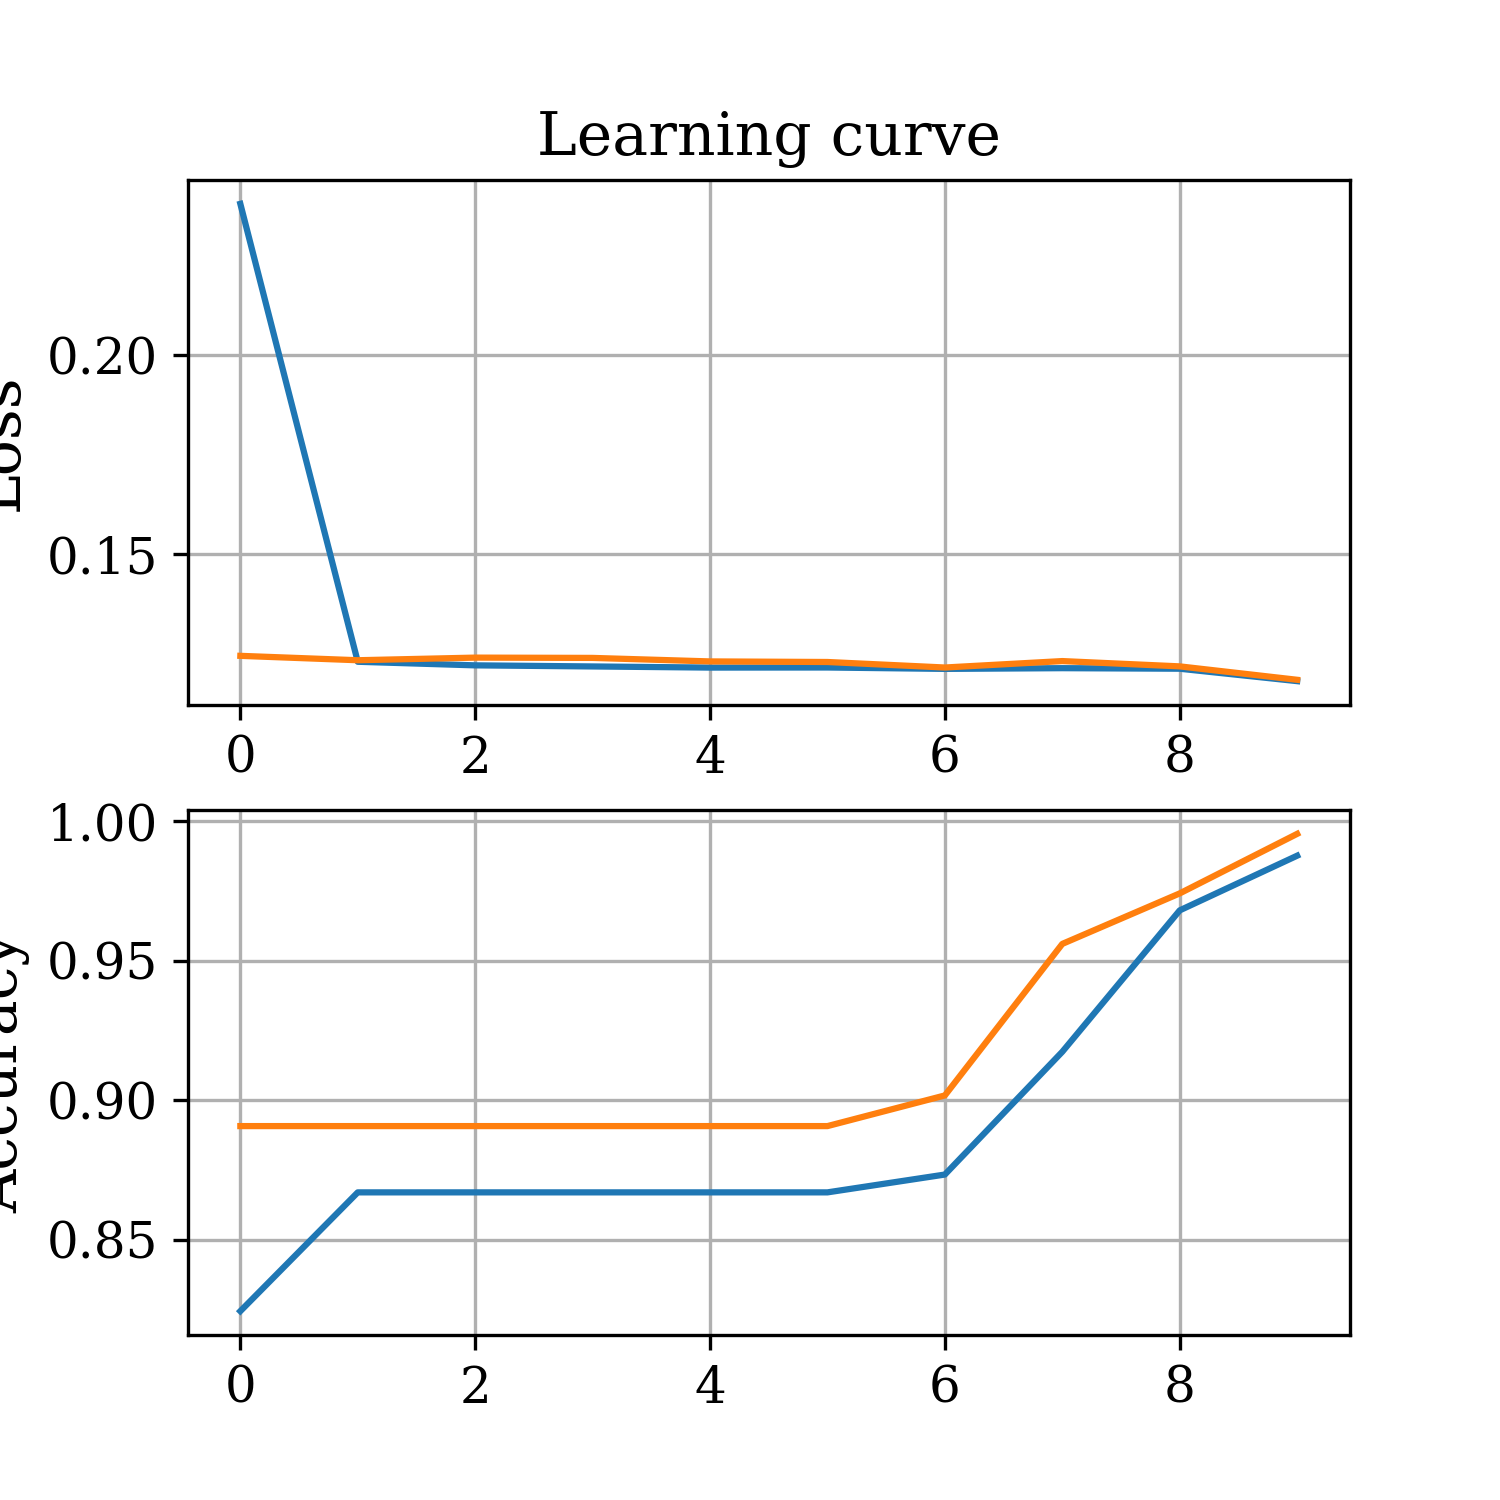

In [25]:
# plot learning curve
print(history)
err = history.history['loss']
val_err = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plots grid
fig, ax = plt.subplots(figsize=(5,5))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0])

# Loss plots
ax0.plot(err, label='Train')
ax0.plot(val_err, label='Test')
ax0.set_ylabel('Loss')

# Accuracy plots
ax1.plot(acc,label='Train')
ax1.plot(val_acc,label='Test')
ax1.set_ylabel('Accuracy')

# General settings
ax0.set_title('Learning curve')
plt.show()
# metrics,values = [],[]
# for k,v in hist.history.items():
#     metrics.append(k)
#     values.append(v)

# fig = plt.figure()  #figsize=(20,10))
# gs = gridspec.GridSpec(len(metrics), 1)
# fig.subplots_adjust(wspace=0.,hspace=0.15)
# axs = []
# for i in range(len(metrics)):
#     if i == 0: axs.append(plt.subplot(gs[i]))  # Original plot
#     else: axs.append( plt.subplot(gs[i], sharex=axs[0]) )  # dists

# for i in range(len(metrics)):
#     ax = axs[i]
#     label = metrics[i]
#     val = values[i]
#     ax.plot(val, label=label)
#     ax.legend()
#     ax.set_ylim(ymin=0)


In [26]:
print('Training data range:',data_dates[0],'<-->',data_dates[-1])
Y_pred = model.predict( np.expand_dims(final_X,axis=0) )[0]
#Y_pred = scaler.inverse_transform(Y_pred)
#final_Y = scaler.inverse_transform(final_Y)

print(final_date.date(),'','       '.join([*columns]))
print('            pred (real)   pred (real)')
Xx,Yy1,Yy2 = [],[],[]
for i in range(final_Y.shape[0]):
    txt = str((final_date+(i+1)*dt.timedelta(days=1)).date())
    for y1,y2 in zip(Y_pred[i],final_Y[i]):
        txt += f'  {y1:.3f}({y2:.3f})'
    Xx.append((final_date+(i+1)*dt.timedelta(days=1)).date())
    Yy1.append(y1)   # real
    Yy2.append(y2)   # prediction
    # txt += '\n'
    print(txt)


Training data range: 1999-02-02 00:00:00 <--> 2020-04-06 00:00:00
2020-04-07  eur2usd       usd2eur
            pred (real)   pred (real)
2020-04-08  1.000(1.087)  0.916(0.920)
2020-04-09  1.000(1.087)  0.916(0.920)


<IPython.core.display.Javascript object>


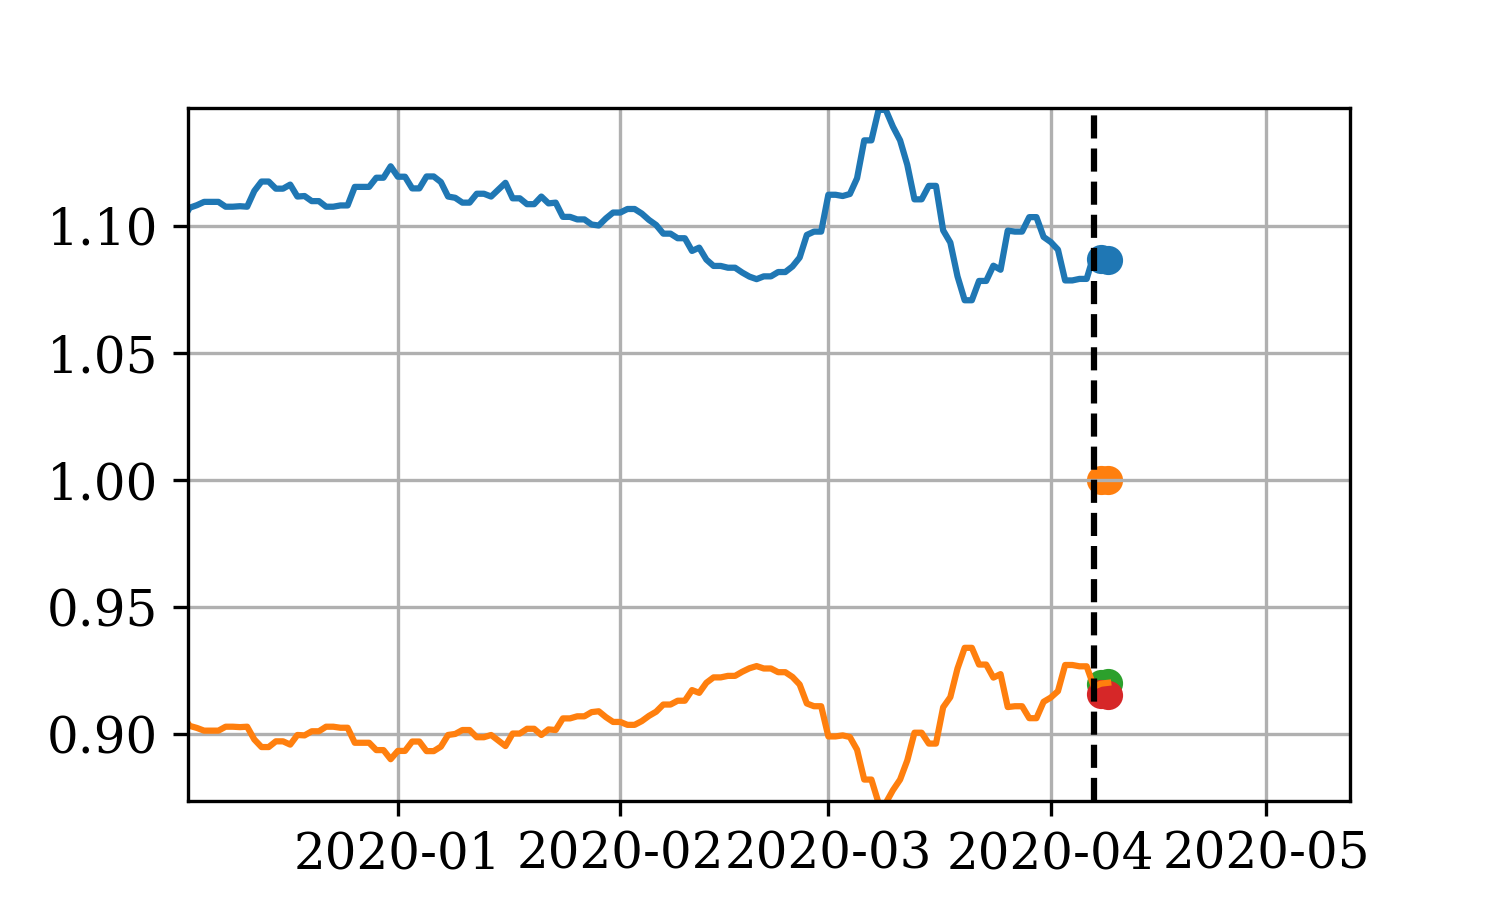

---------


In [27]:
fig, ax = plt.subplots()
# Column 1
ax.plot(df.index,df['eur2usd'])
ax.scatter(Xx,final_Y[:,0])
ax.scatter(Xx,Y_pred[:,0])
# Column 2
ax.plot(df.index,df['usd2eur'])
ax.scatter(Xx,final_Y[:,1])
ax.scatter(Xx,Y_pred[:,1])
ax.axvline(final_date,color='k',ls='--')
plt.show()
print('---------')
model.save(fmodel)